## Demo: repeating a subcycle until a stop condition is triggered with energy and route
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook provides an example of a simulation that takes a number of sub processes, grouped in a sequential activity, that is **executed while a stop condition is not yet met**.

For this example we work with the following sub processes:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [1]:
import datetime, time
import logging

import simpy
import pandas as pd
import shapely
import networkx as nx

import openclsim
import opentnsim

# Used for making the graph to visualize our problem
import matplotlib.pyplot as plt

logger = logging.basicConfig(level=logging.INFO)
logging.root.setLevel(level=logging.INFO)

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 1.1 Create graph

In [3]:
graph = nx.Graph()
my_env.graph = graph

In [4]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
[4.651810765193616,53.06520633542454],
[4.665949515416939,53.06291148049787], 
[4.678223920527591,53.06107438344198], 
[4.688183738253528,53.05974704102928], 
[4.69785320390846 ,53.05828289064841], 
[4.704381491443237,53.05728100125996], 
[4.709772259231658,53.05656711326854]] 

# for each edge (between above coordinates) specify the depth (m)
depths = [20, 18, 16, 14, 11, 8]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [5]:
# create a graph based on coords and depths
nodes = []
path = []
positions = {}

In [6]:
# add nodes
for index, coord in enumerate(coords):
    node = shapely.geometry.Point(coord[0], coord[1])
    name = "Node " + str(index)
    
    positions[node] = (node.x, node.y)
    nodes.append(node)

    my_env.graph.add_node(node, **{"name": name,
                                   "geometry": node})

In [7]:
# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    my_env.graph.add_edge(edge[0], edge[1], weight = 1, Info = {"GeneralDepth": depths[index]})


In [8]:
my_env.graph = my_env.graph.to_undirected() 
my_env.graph = my_env.graph.to_directed() 

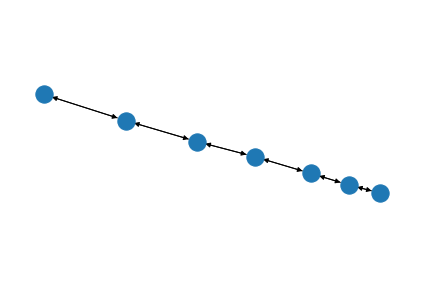

In [9]:
# show graph
nx.draw(my_env.graph, positions)
plt.show()

In [10]:
# inspect if properties were set correctly
for edge in my_env.graph.edges(data = True):
    print('{}, {}: general depth {} m'.format(edge[0], edge[1], graph.edges[(edge[0], edge[1])]['Info']['GeneralDepth']))

POINT (4.651810765193616 53.06520633542454), POINT (4.665949515416939 53.06291148049787): general depth 20 m
POINT (4.665949515416939 53.06291148049787), POINT (4.651810765193616 53.06520633542454): general depth 20 m
POINT (4.665949515416939 53.06291148049787), POINT (4.678223920527591 53.06107438344198): general depth 18 m
POINT (4.678223920527591 53.06107438344198), POINT (4.665949515416939 53.06291148049787): general depth 18 m
POINT (4.678223920527591 53.06107438344198), POINT (4.688183738253528 53.05974704102928): general depth 16 m
POINT (4.688183738253528 53.05974704102928), POINT (4.678223920527591 53.06107438344198): general depth 16 m
POINT (4.688183738253528 53.05974704102928), POINT (4.69785320390846 53.05828289064841): general depth 14 m
POINT (4.69785320390846 53.05828289064841), POINT (4.688183738253528 53.05974704102928): general depth 14 m
POINT (4.69785320390846 53.05828289064841), POINT (4.704381491443237 53.05728100125996): general depth 11 m
POINT (4.7043814914432

#### 2. Define object classes

In [11]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        opentnsim.core.Movable,      # add opentnsim Movable to allow sailing on graph
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.HasResource,
        openclsim.core.HasContainer,
        openclsim.core.Processor,
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [12]:
# prepare input data for from_site
location_from_site = list(my_env.graph.nodes)[0]
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 50
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = list(my_env.graph.nodes)[-1]
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 50,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [13]:
# # prepare input data for vessel_01
# data_vessel01 = {"env": my_env,
#                  "name": "vessel01",
#                  "capacity": 5,
#                  "v": 10,
#                  "geometry": location_from_site, 
# #                  "loading_rate": 0.00001,
# #                  "unloading_rate": 0.00001,
# #                  "capacity": 4,
# #                  "compute_v": lambda x: 10,
#                  # TODO: confirm these numbers
# #                  'v': 3.5,
# #                  'P_installed': 2200, 
# #                  'L_w': 15, 
# #                  'C_b': 0.85, 
# #                  'current_year': 2022,  
# #                  'c_year': 1990,
# #                  'type': 'a',
# #                  'B': 11,
# #                  'L': 135,
# #                  'T': 2.5,
#                  'route': [location_from_site, location_to_site]

                 
#                }
# # instantiate vessel_01 
# vessel01 = TransportProcessingResource(**data_vessel01)

In [14]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": my_env,
    "name": "vessel01",
    "geometry": location_from_site, 
    "capacity": 5,
    "v": 10,
    "route":  nx.dijkstra_path(my_env.graph, location_from_site, location_to_site)
}
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)
assert not vessel01.metadata

In [15]:
vessel01.__dict__

{'v': 10,
 'metadata': {},
 'env': <simpy.core.Environment at 0x1e65aae35b0>,
 'container': <openclsim.core.events_container.EventsContainer at 0x1e65aae3d90>,
 'resource': <simpy.resources.resource.Resource at 0x1e65fcb6700>,
 'log': {'Message': [], 'Timestamp': [], 'Value': [], 'Geometry': []},
 'name': 'vessel01',
 'id': '1965273c-284c-46cf-af31-5d2442ad22bc',
 'route': [<POINT (4.652 53.065)>,
  <POINT (4.666 53.063)>,
  <POINT (4.678 53.061)>,
  <POINT (4.688 53.06)>,
  <POINT (4.698 53.058)>,
  <POINT (4.704 53.057)>,
  <POINT (4.71 53.057)>],
 'complete_path': None,
 'geometry': <POINT (4.652 53.065)>,
 'node': None,
 'wgs84': Geod(ellps='WGS84'),
 'on_pass_edge_functions': []}

##### 3.3 Create activity/activities

In [16]:
# initialise registry
registry = {}

In [17]:
# activity = openclsim.model.MoveActivity(
#     env=my_env,
#     name="Move activity",
#     registry=registry,
#     mover=vessel01,
#     destination=location_to_site,
# )

In [18]:
# create a list of the sub processes
sub_processes = [
    openclsim.model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=location_from_site,
    ),
    openclsim.model.MoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=location_to_site,
    )
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = openclsim.model.SequentialActivity(
    env=my_env,
    name="sequential_activity_subcycle",
    registry=registry,
    sub_processes=sub_processes,
)

# # create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
# while_activity = model.WhileActivity(
#     env=my_env,
#     name="while_sequential_activity_subcycle",
#     registry=registry,
#     sub_processes=[sequential_activity],
#     condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
# )

activity = openclsim.model.RepeatActivity(
    env=my_env,
    name="repeatit",
    registry=registry,
    sub_processes=[sequential_activity],
    repetitions=2
)

#### 4. Register processes and run simpy

In [19]:
# initate the simpy processes defined in the 'while activity' and run simpy
openclsim.model.register_processes([activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [20]:
openclsim.plot.get_log_dataframe(sequential_activity, [activity, *sub_processes])

,Activity,Timestamp,ActivityState,type,ref
0,sequential_activity_subcycle,1970-01-01 00:00:00.000000,START,NaN,NaN
1,sequential_activity_subcycle,1970-01-01 00:00:00.000000,START,subprocess,ccdd4648-8317-40cd-8445-e3c338a8563e
2,sequential_activity_subcycle,1970-01-01 00:06:40.364047,STOP,subprocess,ccdd4648-8317-40cd-8445-e3c338a8563e
3,sequential_activity_subcycle,1970-01-01 00:06:40.364047,START,subprocess,3079c380-365e-4b84-a930-8ebeda78833e
4,sequential_activity_subcycle,1970-01-01 00:20:01.034956,STOP,subprocess,3079c380-365e-4b84-a930-8ebeda78833e
5,sequential_activity_subcycle,1970-01-01 00:20:01.034956,STOP,NaN,NaN
6,sequential_activity_subcycle,1970-01-01 00:20:01.034956,START,NaN,NaN
7,sequential_activity_subcycle,1970-01-01 00:20:01.034956,START,subprocess,ccdd4648-8317-40cd-8445-e3c338a8563e
8,sequential_activity_subcycle,1970-01-01 00:33:21.705864,STOP,subprocess,ccdd4648-8317-40cd-8445-e3c338a8563e
9,sequential_activity_subcycle,1970-01-01 00:33:21.705864,START,subprocess,3079c380-365e-4b84-a930-8ebeda78833e


In [21]:
openclsim.plot.get_log_dataframe(sub_processes[0], [sequential_activity, activity])

,Activity,Timestamp,ActivityState
0,sailing empty,1970-01-01 00:00:00.000000,START
1,sailing empty,1970-01-01 00:06:40.364047,STOP
2,sailing empty,1970-01-01 00:20:01.034956,START
3,sailing empty,1970-01-01 00:33:21.705864,STOP


##### 5.2 Visualise gantt charts

In [22]:
openclsim.plot.get_gantt_chart([activity, sequential_activity, *sub_processes])

#### Sandbox

In [23]:
pd.DataFrame.from_dict(vessel01.log)

,Message,Timestamp,Value,Geometry
0,Sailing from node POINT (4.651810765193616 53....,1970-01-01 01:00:00.000000,0.000000,POINT (4.651810765193616 53.06520633542454)
1,Sailing from node POINT (4.651810765193616 53....,1970-01-01 01:01:38.163477,0.000000,POINT (4.665949515416939 53.06291148049787)
2,Sailing from node POINT (4.665949515416939 53....,1970-01-01 01:01:38.163477,0.000000,POINT (4.665949515416939 53.06291148049787)
3,Sailing from node POINT (4.665949515416939 53....,1970-01-01 01:03:02.954035,0.000000,POINT (4.678223920527591 53.06107438344198)
4,Sailing from node POINT (4.678223920527591 53....,1970-01-01 01:03:02.954035,0.000000,POINT (4.678223920527591 53.06107438344198)
5,Sailing from node POINT (4.678223920527591 53....,1970-01-01 01:04:11.342484,0.000000,POINT (4.688183738253528 53.05974704102928)
6,Sailing from node POINT (4.688183738253528 53....,1970-01-01 01:04:11.342484,0.000000,POINT (4.688183738253528 53.05974704102928)
7,Sailing from node POINT (4.688183738253528 53....,1970-01-01 01:05:18.188357,0.000000,POINT (4.69785320390846 53.05828289064841)
8,Sailing from node POINT (4.69785320390846 53.0...,1970-01-01 01:05:18.188357,0.000000,POINT (4.69785320390846 53.05828289064841)
9,Sailing from node POINT (4.69785320390846 53.0...,1970-01-01 01:06:03.356714,0.000000,POINT (4.704381491443237 53.05728100125996)
